# Airline Delays vs Temperature | Dew
*Benny*

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import hvplot.pandas
import requests
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from dotenv import dotenv_values
from helpers import getWeatherData

geoapify_key = dotenv_values().get('geoapify_key')
weather_key = dotenv_values().get('weather_key')
warnings.filterwarnings("ignore")

df = pd.read_csv('../../data/clean_2018_3_Days.csv')

In [3]:
df.head()

,Flight_Date,Origin_Airport,Destination_Airport,Flight_Number,Operating_Carrier,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay,Scheduled_Departure_Time,Actual_Departure_Time,...,Destination Cloud Cover,Destination Dew,Destination Humidity,Destination Precipitation,Destination Pressure,Destination Snow,Destination Temperature,Destination Visibility,Destination Windspeed,Destination Precipitation Probability
0,2018-07-20,ABQ,AUS,5929,WN,1900,1917.0,17.0,1625,1644.0,...,7.8,68.6,51.96,0.0,1013.0,0.0,88.5,9.9,6.7,0.0
1,2018-07-20,ABQ,BWI,2377,WN,2155,2222.0,27.0,1615,1624.0,...,67.1,57.3,39.19,0.0,1017.9,0.0,84.9,9.9,5.8,0.0
2,2018-07-20,ABQ,BWI,2504,WN,1410,1441.0,31.0,825,834.0,...,53.4,66.9,78.19,0.0,1020.0,0.0,74.1,9.9,0.7,0.0
3,2018-07-20,ABQ,DAL,15,WN,905,850.0,-15.0,620,618.0,...,28.8,59.6,31.21,0.0,1010.9,0.0,94.7,9.9,13.1,0.0
4,2018-07-20,ABQ,DAL,942,WN,1620,1622.0,2.0,1340,1339.0,...,28.8,59.6,31.21,0.0,1010.9,0.0,94.7,9.9,13.1,0.0


In [4]:
delays_mean = df.groupby('Flight_Date')['Arrival_Delay'].mean()

delays_mean

Flight_Date
2018-07-20    17.004003
2018-07-23    24.376000
2018-07-24    16.928140
Name: Arrival_Delay, dtype: float64

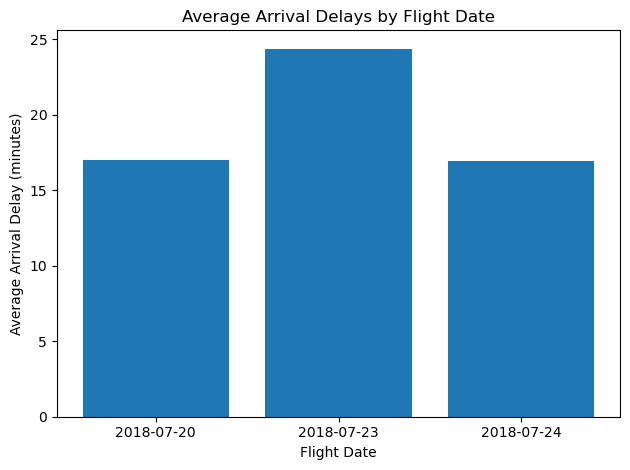

In [5]:
plt.bar(delays_mean.index, delays_mean.values)
plt.xlabel('Flight Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delays by Flight Date')
plt.tight_layout()
plt.show()

In [5]:
dep_delays_df = df[df['Departure_Delay'] > 0]
arr_delays_df = df[df['Arrival_Delay'] > 0]

## Created a function to create a statistical summary on our data set for Arrival and Departure Delays

In [7]:
def stats_summary(list_of_series):

    mean, median, mode, norm_test, std_dev, lq, uq, inter_q, l_thres, u_thres = [[] for _ in range(10)]


    for df in list_of_series:
        mean.append(np.mean(df))
        mode.append(st.mode(df, keepdims=False))
        norm_test.append(st.normaltest(df))
        std_dev.append(np.std(df))
        lq_, median_, uq_ = df.quantile([.25, .5, .75])
        lq.append(lq_)
        uq.append(uq_)
        median.append(median_)
        inter_q.append(uq_ - lq_)
        lThres_, uThres_ = st.mstats.mquantiles(df, [0.25, 0.75])
        l_thres.append(lThres_)
        u_thres.append(uThres_)

    mode_ = []
    for i in mode:
        mode_.append(i[0])
    p_val = []
    statistics = []
    for i in norm_test:
        p_val.append(i[1])
        statistics.append(i[0])

    stats_df = pd.DataFrame({
        'Mean': mean,
        'Median': median,
        'Mode': mode_,
        'P Value': p_val,
        'Statistics': statistics,
        'Standard Deviation': std_dev,
        'Lower Quartile': lq,
        'Upper Quartile': uq,
        'Interquartile Range': inter_q,
        'Lower Threshold': l_thres,
        'Upper Threshold': u_thres,
    }, index=['Delay','Temperature','Windspeed', 'Precipitation', 'Dew'])

    return stats_df

# Statistical Summary for Departures

In [8]:
df_list_dep = [dep_delays_df['Departure_Delay'], dep_delays_df['Origin Temperature'], dep_delays_df['Origin Windspeed'], dep_delays_df['Origin Precipitation'], dep_delays_df['Origin Dew']]
df_list_arr = [dep_delays_df['Arrival_Delay'], dep_delays_df['Destination Temperature'], dep_delays_df['Destination Windspeed'], dep_delays_df['Destination Precipitation'], dep_delays_df['Destination Dew']]

stats_sum_dep = stats_summary(df_list_dep)
stats_sum_dep

,Mean,Median,Mode,P Value,Statistics,Standard Deviation,Lower Quartile,Upper Quartile,Interquartile Range,Lower Threshold,Upper Threshold
Delay,50.137786,26.0,1.0,0.000000e+00,35148.004900,71.630100,9.0,67.0,58.0,9.0,67.0
Temperature,78.726377,78.4,70.2,2.341480e-191,877.885939,8.769983,73.0,83.5,10.5,73.0,83.5
Windspeed,7.497486,7.0,9.9,6.268684e-209,958.809436,4.011997,4.8,10.1,5.3,4.8,10.1
Precipitation,0.007880,0.0,0.0,0.000000e+00,49207.441236,0.045206,0.0,0.0,0.0,0.0,0.0
Dew,65.096398,66.1,61.9,0.000000e+00,2113.109507,8.045275,59.9,71.7,11.8,59.9,71.7


# Statistical Summary for Arrivals

In [9]:
stats_sum_arr = stats_summary(df_list_arr)
stats_sum_arr

,Mean,Median,Mode,P Value,Statistics,Standard Deviation,Lower Quartile,Upper Quartile,Interquartile Range,Lower Threshold,Upper Threshold
Delay,47.313756,25.0,2.0,0.000000e+00,33556.030626,73.442333,4.0,68.00,64.00,4.0,68.00
Temperature,78.602773,78.5,70.2,1.397811e-127,584.186798,8.846570,72.9,83.65,10.75,72.9,83.68
Windspeed,7.553613,7.1,5.8,3.838786e-181,830.845491,4.095088,4.7,10.10,5.40,4.7,10.10
Precipitation,0.006769,0.0,0.0,0.000000e+00,53035.083887,0.039876,0.0,0.00,0.00,0.0,0.00
Dew,65.054607,66.0,67.9,0.000000e+00,2297.675839,8.204313,59.9,72.00,12.10,59.9,72.00


## Correlation results for Temperature and Dew Point Temperature

In [10]:
correlation = st.pearsonr(dep_delays_df['Departure_Delay'], dep_delays_df['Origin Temperature'])
print(f"The correlation between Departure Delay and Temperature {round(correlation[0],2)}")

The correlation between Departure Delay and Temperature -0.03


In [11]:
correlation = st.pearsonr(dep_delays_df['Arrival_Delay'], dep_delays_df['Destination Temperature'])
print(f"The correlation between Arrival Delay and Temperature is {round(correlation[0],2)}")

The correlation between Arrival Delay and Temperature is -0.01


In [12]:
correlation = st.pearsonr(dep_delays_df['Departure_Delay'], dep_delays_df['Origin Dew'])
print(f"The correlation between Departure Delay and Dew Point Temperature is {round(correlation[0],2)}")

The correlation between Departure Delay and Dew Point Temperature is 0.1


In [13]:
correlation = st.pearsonr(arr_delays_df['Arrival_Delay'], arr_delays_df['Destination Dew'])
print(f"The correlation between Arrival Delay and Dew Point Temperature is {round(correlation[0],2)}")

The correlation between Arrival Delay and Dew Point Temperature is 0.1


# Delays vs Temperature

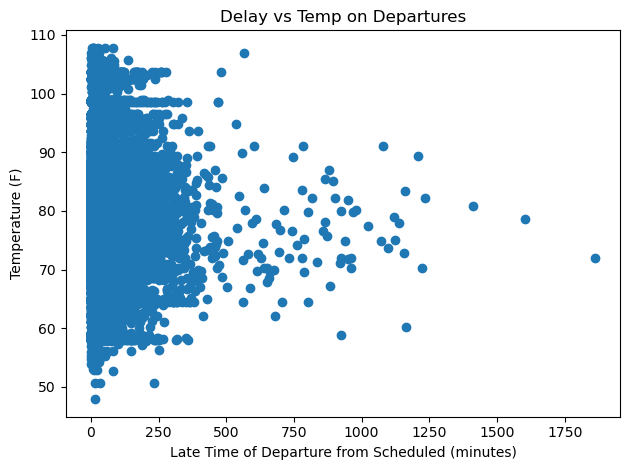

In [14]:
plt.scatter(dep_delays_df['Departure_Delay'], dep_delays_df['Origin Temperature'])
plt.xlabel('Late Time of Departure from Scheduled (minutes)')
plt.ylabel('Temperature (F)')
plt.title('Delay vs Temp on Departures')
plt.tight_layout()
plt.show()

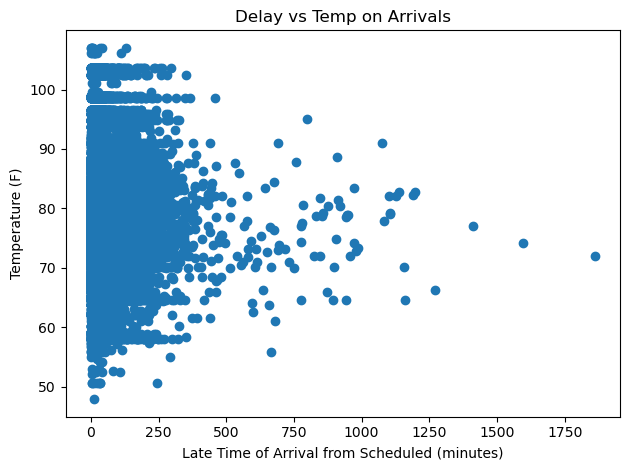

In [15]:
plt.scatter(arr_delays_df['Arrival_Delay'], arr_delays_df['Destination Temperature'])
plt.xlabel('Late Time of Arrival from Scheduled (minutes)')
plt.ylabel('Temperature (F)')
plt.title('Delay vs Temp on Arrivals')
plt.tight_layout()
plt.show()

# Delays vs Dew Point Temp

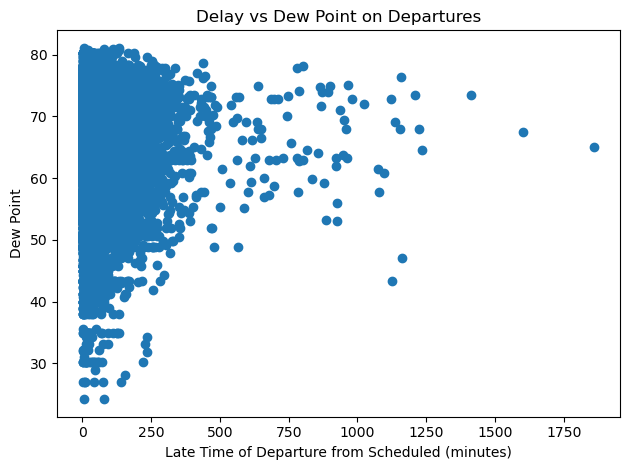

In [16]:
plt.scatter(dep_delays_df['Departure_Delay'], dep_delays_df['Origin Dew'])
plt.xlabel('Late Time of Departure from Scheduled (minutes)')
plt.ylabel('Dew Point')
plt.title('Delay vs Dew Point on Departures')
plt.tight_layout()
plt.show()

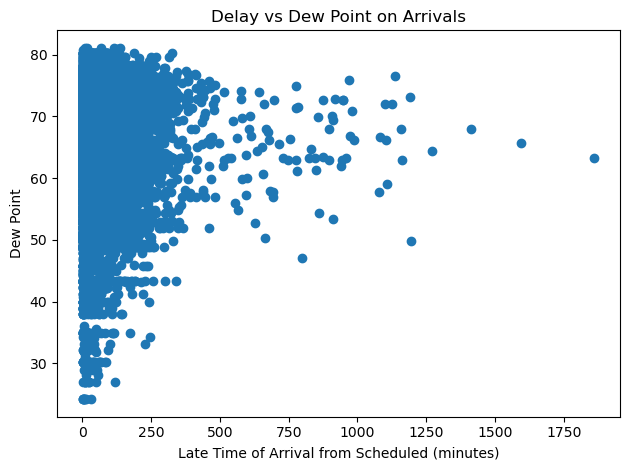

In [17]:
plt.scatter(arr_delays_df['Arrival_Delay'], arr_delays_df['Destination Dew'])
plt.xlabel('Late Time of Arrival from Scheduled (minutes)')
plt.ylabel('Dew Point')
plt.title('Delay vs Dew Point on Arrivals')
plt.tight_layout()
plt.show()

# Delays vs Temperature (Linear Regression)

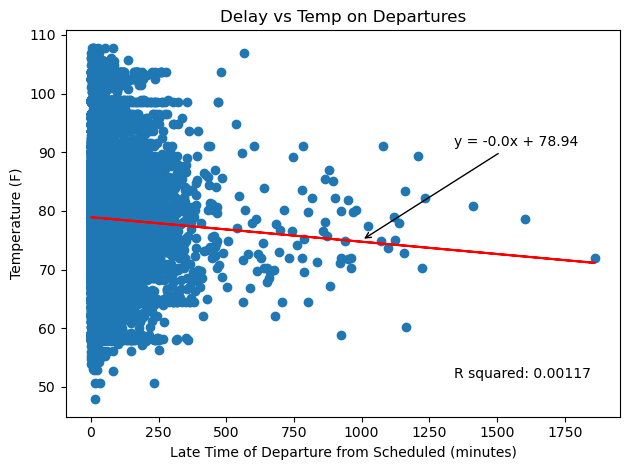

In [18]:
x_values = dep_delays_df['Departure_Delay']
y_values = dep_delays_df['Origin Temperature']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.xlabel('Late Time of Departure from Scheduled (minutes)')
plt.ylabel('Temperature (F)')
plt.title('Delay vs Temp on Departures')

# Plot regression line
plt.plot(x_values,regress_values,"r-")
rSqr = f"R squared: {round(rvalue**2, 5)}"
plt.annotate(line_eq, (1000, 75), xytext=(0.7, 0.7), textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(rSqr, (1000, 75), xytext=(0.7, 0.1), textcoords='axes fraction')

plt.tight_layout()
plt.show()

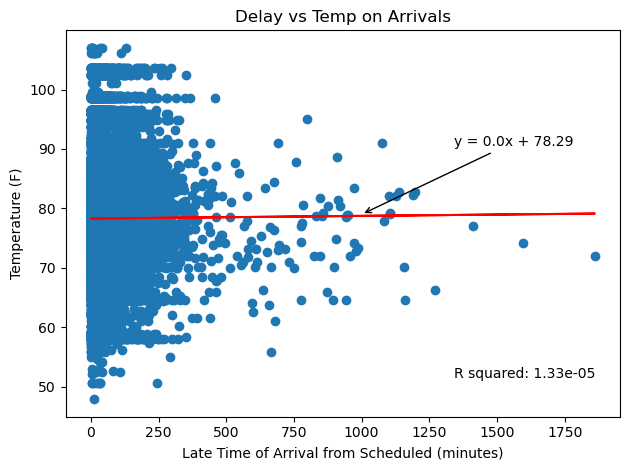

In [19]:
x_values = arr_delays_df['Arrival_Delay']
y_values = arr_delays_df['Destination Temperature']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.xlabel('Late Time of Arrival from Scheduled (minutes)')
plt.ylabel('Temperature (F)')
plt.title('Delay vs Temp on Arrivals')

# Plot regression line
plt.plot(x_values,regress_values,"r-")
rSqr = f"R squared: {round(rvalue**2, 7)}"
plt.annotate(line_eq, (1000, 79), xytext=(0.7, 0.7), textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(rSqr, (1000, 75), xytext=(0.7, 0.1), textcoords='axes fraction')

plt.tight_layout()
plt.show()

# Delay vs Dew Point Temperature (Linear Regression)

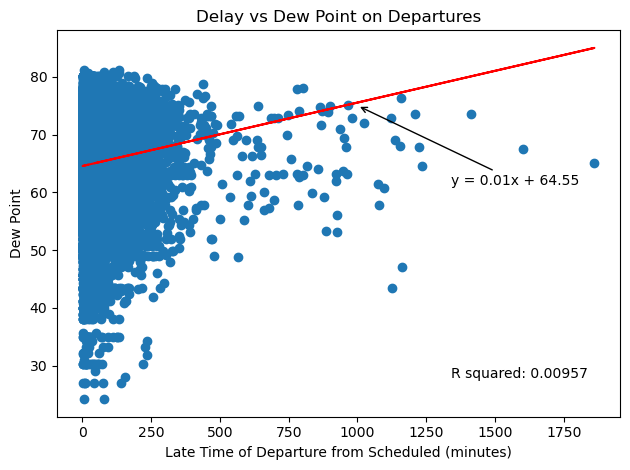

In [20]:
x_values = dep_delays_df['Departure_Delay']
y_values = dep_delays_df['Origin Dew']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.xlabel('Late Time of Departure from Scheduled (minutes)')
plt.ylabel('Dew Point')
plt.title('Delay vs Dew Point on Departures')

# Plot regression line
plt.plot(x_values,regress_values,"r-")
rSqr = f"R squared: {round(rvalue**2, 5)}"
plt.annotate(line_eq, (1000, 75), xytext=(0.7, 0.6), textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(rSqr, (1000, 75), xytext=(0.7, 0.1), textcoords='axes fraction')

plt.tight_layout()
plt.show()

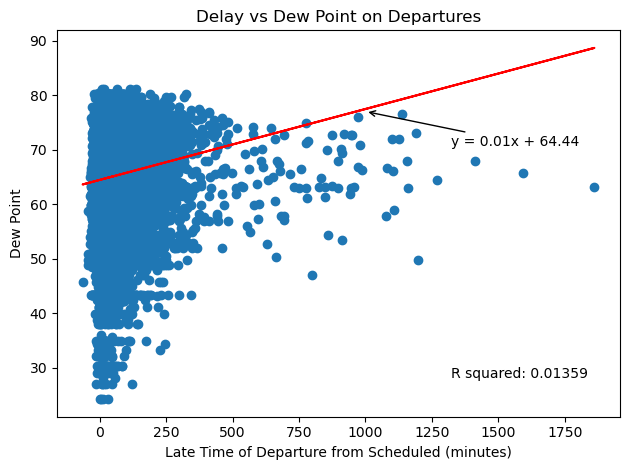

In [21]:
x_values = dep_delays_df['Arrival_Delay']
y_values = dep_delays_df['Destination Dew']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.xlabel('Late Time of Departure from Scheduled (minutes)')
plt.ylabel('Dew Point')
plt.title('Delay vs Dew Point on Departures')

# Plot regression line
plt.plot(x_values,regress_values,"r-")
rSqr = f"R squared: {round(rvalue**2, 5)}"
plt.annotate(line_eq, (1000, 77), xytext=(0.7, 0.7), textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(rSqr, (1000, 75), xytext=(0.7, 0.1), textcoords='axes fraction')

plt.tight_layout()
plt.show()

# Cities organized by delay count

In [55]:
cities = []
for _, row in df.iterrows():

    arrival = row['Arrival City']
    depart = row['Departure City']

    if arrival  not in cities:
        cities.append(arrival)
    elif depart not in cities:
        cities.append(depart)

len(cities)

333

In [56]:
# Set the search parameters
apiKey = f'&apiKey={geoapify_key}'
url = f"https://api.geoapify.com/v1/geocode/search?text="
city_data = []

for city in cities:
    res = requests.get(f'{url}{city}{apiKey}').json()
    try:
        city_data.append(
            (res['features'][0]['properties']['lon'],
            res['features'][0]['properties']['lat'],
            city)
        )
    except:
        print(f'Error on this city: {city}')

Error on this city: Christiansted, Virgin Islands


In [69]:
cities_dict = {}

for city in city_data:
    cities_dict[city[2]] = [city[2], city[0], city[1], 0]

In [70]:
dep_delays_df = df[df['Departure_Delay'] > 0]
arr_delays_df = df[df['Arrival_Delay'] > 0]

In [66]:
def count_delays_per_city(df, dict):
    for _, row in df.iterrows():
        arrival = row['Arrival City']
        depart = row['Departure City']

        if arrival  in dict:
            dict[arrival][3] = dict[arrival][3] + 1
        elif depart in cities:
            dict[depart][3] = dict[depart][3] + 1

In [72]:
count_delays_per_city(dep_delays_df, cities_dict)
count_delays_per_city(arr_delays_df, cities_dict)

In [75]:
cities_dict.values()

dict_values([['Albuquerque, New Mexico', -106.650985, 35.0841034, 179], ['Baltimore, Maryland', -76.610759, 39.2908816, 1230], ['Dallas, Texas', -96.7968559, 32.7762719, 703], ['Denver, Colorado', -104.984862, 39.7392364, 2213], ['Houston, Texas', -95.3676974, 29.7589382, 1595], ['Las Vegas, Nevada', -115.148516, 36.1672559, 1576], ['Los Angeles, California', -118.242766, 34.0536909, 1722], ['Kansas City, Missouri', -94.5781416, 39.100105, 404], ['Chicago, Illinois', -87.6244212, 41.8755616, 4392], ['Oakland, California', -122.271356, 37.8044557, 505], ['Portland, Oregon', -122.674194, 45.5202471, 561], ['Phoenix, Arizona', -112.074141, 33.4484367, 1409], ['San Diego, California', -117.1627728, 32.7174202, 745], ['Santa Ana, California', -117.8732213, 33.7494951, 235], ['Albany, New York', -73.754968, 42.6511674, 100], ['Fort Lauderdale, Florida', -80.1433786, 26.1223084, 972], ['Orlando, Florida', -81.3790304, 28.5421109, 1601], ['Tampa, Florida', -82.458444, 27.9477595, 770], ['Amari

In [ ]:
cities_df = pd.DataFrame(cities_dict.values(), columns=['City, State', 'Longitude', 'Latitude',	'Number of Delays'])

cities_df.head()

In [ ]:
cities_df['C']

In [79]:
delay_per_city_map = cities_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo=True,
    tiles="OSM",
    frame_width=1000,
    frame_height=800,
    size = "Number of Delays",
    scale = .3,
    color = "City, State",
    hover_cols = ["City, State"]
)

delay_per_city_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (City, State,Number of Delays)

# Logistics Regression Model

##### logistic regression is a classification algorithm widely used statistical method for binary classification tasks.

In [26]:
# make a new binary column for our target variable
df['is_delayed'] = (df['Arrival_Delay'] > 0 ) | (df['Departure_Delay'] > 0)
df.head()

,Flight_Date,Origin_Airport,Destination_Airport,Flight_Number,Operating_Carrier,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay,Scheduled_Departure_Time,Actual_Departure_Time,...,Destination Dew,Destination Humidity,Destination Precipitation,Destination Pressure,Destination Snow,Destination Temperature,Destination Visibility,Destination Windspeed,Destination Precipitation Probability,is_delayed
0,2018-07-20,ABQ,AUS,5929,WN,1900,1917.0,17.0,1625,1644.0,...,68.6,51.96,0.0,1013.0,0.0,88.5,9.9,6.7,0.0,True
1,2018-07-20,ABQ,BWI,2377,WN,2155,2222.0,27.0,1615,1624.0,...,57.3,39.19,0.0,1017.9,0.0,84.9,9.9,5.8,0.0,True
2,2018-07-20,ABQ,BWI,2504,WN,1410,1441.0,31.0,825,834.0,...,66.9,78.19,0.0,1020.0,0.0,74.1,9.9,0.7,0.0,True
3,2018-07-20,ABQ,DAL,15,WN,905,850.0,-15.0,620,618.0,...,59.6,31.21,0.0,1010.9,0.0,94.7,9.9,13.1,0.0,False
4,2018-07-20,ABQ,DAL,942,WN,1620,1622.0,2.0,1340,1339.0,...,59.6,31.21,0.0,1010.9,0.0,94.7,9.9,13.1,0.0,True


In [27]:
# seperate all weather data
weather_df = df[['Origin Cloud Cover', 'Origin Dew', 'Origin Humidity',
       'Origin Precipitation', 'Origin Pressure', 'Origin Snow',
       'Origin Temperature', 'Origin Visibility', 'Origin Windspeed',
       'Origin Precipitation Probability', 'Destination Cloud Cover',
       'Destination Dew', 'Destination Humidity', 'Destination Precipitation',
       'Destination Pressure', 'Destination Snow', 'Destination Temperature',
       'Destination Visibility', 'Destination Windspeed',
       'Destination Precipitation Probability', 'is_delayed']]
weather_df.head()

,Origin Cloud Cover,Origin Dew,Origin Humidity,Origin Precipitation,Origin Pressure,Origin Snow,Origin Temperature,Origin Visibility,Origin Windspeed,Origin Precipitation Probability,...,Destination Dew,Destination Humidity,Destination Precipitation,Destination Pressure,Destination Snow,Destination Temperature,Destination Visibility,Destination Windspeed,Destination Precipitation Probability,is_delayed
0,87.6,51.1,33.3,0.0,1011.8,0.0,82.9,9.9,9.1,0.0,...,68.6,51.96,0.0,1013.0,0.0,88.5,9.9,6.7,0.0,True
1,87.6,51.1,33.3,0.0,1011.8,0.0,82.9,9.9,9.1,0.0,...,57.3,39.19,0.0,1017.9,0.0,84.9,9.9,5.8,0.0,True
2,87.6,51.1,33.3,0.0,1011.8,0.0,82.9,9.9,9.1,0.0,...,66.9,78.19,0.0,1020.0,0.0,74.1,9.9,0.7,0.0,True
3,87.6,51.1,33.3,0.0,1011.8,0.0,82.9,9.9,9.1,0.0,...,59.6,31.21,0.0,1010.9,0.0,94.7,9.9,13.1,0.0,False
4,87.6,51.1,33.3,0.0,1011.8,0.0,82.9,9.9,9.1,0.0,...,59.6,31.21,0.0,1010.9,0.0,94.7,9.9,13.1,0.0,True


In [28]:
weather_df['is_delayed'].value_counts()

True     36961
False    25544
Name: is_delayed, dtype: int64

In [ ]:
df = weather_df.copy()

In [33]:
# Separate features and target variable
X = df[['Origin Cloud Cover', 'Origin Dew', 'Origin Humidity',
       'Origin Precipitation', 'Origin Pressure', 'Origin Snow',
       'Origin Temperature', 'Origin Visibility', 'Origin Windspeed',
       'Origin Precipitation Probability', 'Destination Cloud Cover',
       'Destination Dew', 'Destination Humidity', 'Destination Precipitation',
       'Destination Pressure', 'Destination Snow', 'Destination Temperature',
       'Destination Visibility', 'Destination Windspeed',
       'Destination Precipitation Probability']]
y = df['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


# Model Tuning

In [90]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#####  The C parameter is the inverse of the regularization strength.the smaller the C, the stronger the regularization, and the larger the C, the weaker the regularization. It means that a high C value will make the logistic regression model behave more like a standard linear regression, while a low C value will encourage the model to be more regularized.

In [95]:
param_grid = {'C': [0.41, 0.42, 0.43, 0.44, 0.45, 0.46]}

# GridSearchCV automates the process of tuning hyperparameters by searching through a predefined set of hyperparameter values
# and finding the best combination that maximizes the model's performance based on a specified evaluation metric.
grid_search = GridSearchCV(model, param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Best Hyperparameters: {'C': 0.43}
Accuracy: 0.61


In [114]:
# make function to predict flight delay
# Example params: ('2023-07-01', 1825, 'Denver, Colorado', 'Atlanta, Georgia')
def flight_prediction(flight_date, fl_time, Departure_city, Arrival_city):
    # URL params
    url = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'
    unitGroup = 'unitGroup=us'
    contentType = 'contentType=json'

    resp = requests.get(f"{url}{Departure_city}/{flight_date}/{flight_date}?{unitGroup}&key={weather_key}&{contentType}").json()
    arr_weather_data = getWeatherData(resp, int(fl_time))
    resp = requests.get(f"{url}{Arrival_city}/{flight_date}/{flight_date}?{unitGroup}&key={weather_key}&{contentType}").json()
    dep_weather_data = getWeatherData(resp, int(fl_time))

    df = pd.DataFrame({
        'Origin Cloud Cover': dep_weather_data['cloudcover'], 
        'Origin Dew': dep_weather_data['dew'], 
        'Origin Humidity': dep_weather_data['humidity'],
        'Origin Precipitation': dep_weather_data['precip'], 
        'Origin Pressure': dep_weather_data['pressure'], 
        'Origin Snow': dep_weather_data['snow'],
        'Origin Temperature': dep_weather_data['temp'], 
        'Origin Visibility': dep_weather_data['visibility'], 
        'Origin Windspeed': dep_weather_data['windspeed'],
        'Origin Precipitation Probability': dep_weather_data['precipprob'],
        'Destination Cloud Cover': arr_weather_data['cloudcover'],
        'Destination Dew': arr_weather_data['dew'], 
        'Destination Humidity': arr_weather_data['humidity'], 
        'Destination Precipitation': arr_weather_data['precip'],
        'Destination Pressure': arr_weather_data['pressure'], 
        'Destination Snow': arr_weather_data['snow'], 
        'Destination Temperature': arr_weather_data['temp'],
        'Destination Visibility': arr_weather_data['visibility'], 
        'Destination Windspeed': arr_weather_data['windspeed'],
        'Destination Precipitation Probability': arr_weather_data['precipprob']
    }, index=[20])

    y_pred = best_model.predict(df)

    return y_pred

In [116]:
# Get user data and predict flight delay
flight_date = '2023-07-31'
fl_time = '1835'
departure_city = 'Denver, Colorado'
arrival_city = 'Atlanta, Georgia'

delayed = flight_prediction(flight_date, fl_time, departure_city, arrival_city)

if delayed:
    print("There is a chance your flight will be delayed due to weather.")
else:
    print("There is a chance your flight will not be delayed due to weather.")

There is a chance your flight will be delayed due to weather.
